In [1]:
%matplotlib inline

import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import sklearn.neighbors._base
import sys

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
import seaborn as sns

# MNIST digits analysis

Design of a CNN architecture and its training, in particular, the CNN has to be designed with the aim of reaching the maximum possible accuracy on the test set, with the hard constraint of a maximum of 6K learnable parameters.

## Report summary
The model consists of an input layer, two convolutional layers, two max pooling layers and a dense, non convolutional layer for classification.  
In order to respect the constraint on the number of parameters the first convolutional layer is built with 16 nodes, the second convolutional layer has 31 nodes(originally 32 but, in that way, the maximum number of parametrs was exceeded by 59) and the non convolutional layer has 10 nodes. No padding is added in any part of the network.  
All the kernel sizes are set to 3x3, the same is true for the pool size in the max pooling layers. This, again, is a choice made to reduce the number of parameters needed. Otherwise a 2x2 pooling would have been better.  
By appling this procedure the output shape changes as follows. The first layer, with 160 parameters, reduces the input size from 28x28 to a 26x26, then the first pooling layer performs a second reduction to a 8x8. At this point the second convolutional layer, with 4495 parameters, scales the input down to a 6x6 and, finally, the las pooling operation gives back a 2x2 output. After flattening the image, a neural network with 1250 parameters performs the classification. The total number of parameters is, therefore, 5905.  
As for the hyperparameters a relu function is used in each convolutional layer, the final classification, on the other hand, is performed with a softmax function. This choice derives from the multilabel nature of the classification. For the same reason a categorical cross entropy is adopted as a loss function.  
Being a classsification problem the metrics kept under observation is the accuracy in the predictions. As an optimizer an adam algorithm is employed, slightly better than the normal gradient descent thanks to its ability to employ the momentum for each step.  
The batch size is set at 128 and, in order to keep under control the evolution of the algorithm during the epochs, a validation set is created with a 20% split on the training set.  
The regularization techniques employed are two. A dropout procedure on the non convolutional network and an early stopping algorithm for the number of epochs on which the model must be trained. This algorithm determined that after 26 epochs the validation loss does not become any lower, this result is obtained considering a margin of 2 epochs with no improvement (patience). 

In the plot below the training history is visualized. The validation loss shrinks untill reaching very low levels, while the validation accuracy peaks at more than 98%. The validation loss looks lower than the training loss, this can be explained by the presence of a dropout procedure. During the fitting phase Keras applies this procedure only on the training data, therefore their values become higher.  
After the training is completed the model is evaluated on a test set. Total accuracy on new, unseen, data is 98.7%, while the value of the loss function is little more than 0.04.  
In order to better assess the model's performance a confusion matrix is plotted. The rows are meant to represent the actual values, while the columns are the values predicted by our model; in each cell it is printed the number of values classified accordingly by the model. The high level of accuracy is easily shown by the extremely high values on the diagonal of the matrix, representing the observations correcly classified and by the low values of each cell outside the diagonal itself.

In [2]:
# define data
num_classes = 10
input_shape = (28,28,1)

# load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

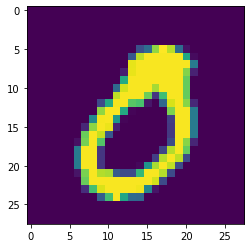

In [3]:
# example of data
plt.imshow(x_train[75])

In [4]:
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28), x_test shape: (10000, 28, 28)


In [5]:
# Scale images from 0 to 1
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"x_train new shape: {x_train.shape}, x_test new shape: {x_test.shape}")

x_train new shape: (60000, 28, 28, 1), x_test new shape: (10000, 28, 28, 1)


In [6]:
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (60000,), x_test shape: (10000,)


In [7]:
#Convert from one dimensional vectors containing labels of the images to categorical labels, in a one-hot encoding shape
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (60000, 10), x_test shape: (10000, 10)


In [8]:
#define the model
model = keras.Sequential (
    [
        keras.Input(shape = input_shape),
        layers.Conv2D(16, kernel_size = (3, 3), activation = "relu"), 
        layers.MaxPooling2D(pool_size=(3, 3)), 
        layers.Conv2D(31, kernel_size = (3, 3), activation = "relu"), 
        layers.MaxPooling2D(pool_size=(3, 3)), #end of convolution 
        layers.Flatten(), #destroy data for fully connected network
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation = "softmax") #softmax for multilabel callification task
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 31)          4495      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 31)          0         
_________________________________________________________________
flatten (Flatten)            (None, 124)               0         
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [9]:
#training on training set
batch_size = 128

model.compile(loss= "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2) 
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, validation_split = 0.2, callbacks=[es]) # 20% validation
stopped = es.stopped_epoch

Epoch 1/1000
375/375 [==============================] - 8s 19ms/step - loss: 1.0081 - accuracy: 0.6779 - val_loss: 0.2321 - val_accuracy: 0.9433
Epoch 2/1000
375/375 [==============================] - 6s 17ms/step - loss: 0.3692 - accuracy: 0.8872 - val_loss: 0.1465 - val_accuracy: 0.9607
Epoch 3/1000
375/375 [==============================] - 6s 17ms/step - loss: 0.2817 - accuracy: 0.9154 - val_loss: 0.1158 - val_accuracy: 0.9688
Epoch 4/1000
375/375 [==============================] - 6s 17ms/step - loss: 0.2393 - accuracy: 0.9269 - val_loss: 0.1001 - val_accuracy: 0.9728
Epoch 5/1000
375/375 [==============================] - 6s 17ms/step - loss: 0.2153 - accuracy: 0.9336 - val_loss: 0.0914 - val_accuracy: 0.9734
Epoch 6/1000
375/375 [==============================] - 6s 17ms/step - loss: 0.1945 - accuracy: 0.9402 - val_loss: 0.0802 - val_accuracy: 0.9777
Epoch 7/1000
375/375 [==============================] - 6s 16ms/step - loss: 0.1795 - accuracy: 0.9454 - val_loss: 0.0773 - val_ac

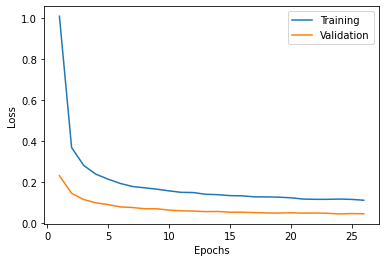

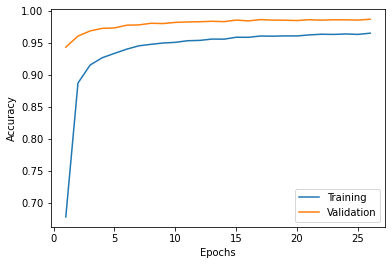

In [10]:
from matplotlib import pyplot as plt
x_plot = list(range(1,stopped+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history) # training loss lower than validation loss because of dropout procedure

In [11]:
#evaluation on test set
score = model.evaluate(x_test, y_test)
print("test loss:", score[0])
print("test accuracy:", score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0443 - accuracy: 0.9863
test loss: 0.044311825186014175
test accuracy: 0.986299991607666


In [12]:
# confusion matrix for multilabel problems
from sklearn.metrics import confusion_matrix

predict = model.predict(x_test, batch_size = batch_size)
classes =  np.argmax(predict,axis=1)
numbers = list(range(0,10))
y_test_nc = np.argmax(y_test, axis=1)

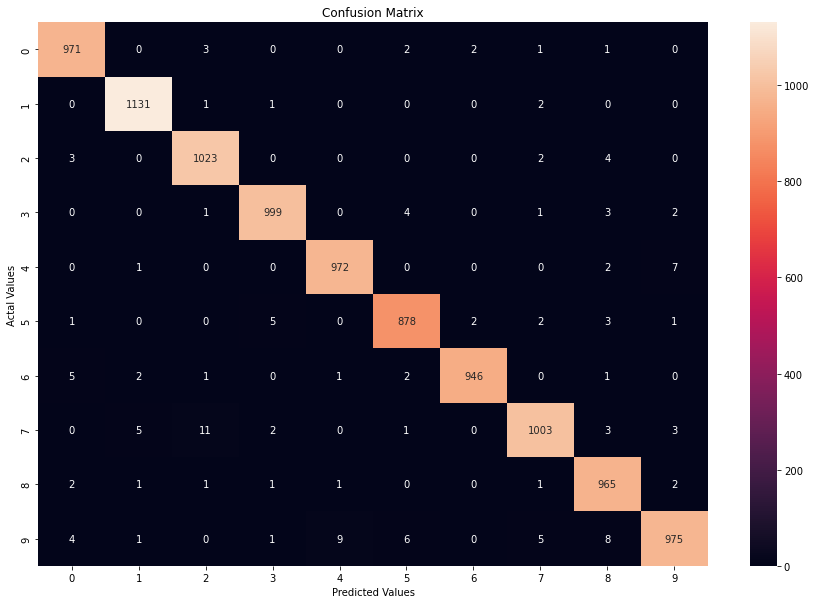

In [13]:
cm = confusion_matrix(y_test_nc, classes)
cm_df = pd.DataFrame(cm,
                     index = numbers, 
                     columns = numbers)

#Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()